# Written by Nina Nurrahmawati
# for NYU CUSP PUI


- Come up with a question about the Citibike data usage. It can be anything that involves Categorical data. 
At this point of the class it is easier to run tests of proportions or similar, and work with categorical data. Categorical cn be anhything that can be punt into classes (e.g. day/night, male/female, 2014/2015/2016.... as long as you set up your experiment the proper way!)
- Choose the significance threshold
- Clearly state they Null and Alternate hypothesis
- Wrangle the data so that it is ready for your analysis.

In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os

%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

import os
import json

Populating the interactive namespace from numpy and matplotlib


## IDEA:
Long distance trips are less likely happens on weekdays than short distance trip on weekdays

### NULL HYPOTHESIS:
The ratio of long distance trips by men is less than or equal to the ratio of long distance trips by women.
The ratio of man biking on weekends over man biking on weekdays is _the same_ or _higher_  than the ratio of woman biking over weekends to woman biking on weekdays

 _$H_0$_ : $\frac{L_{\mathrm{weekend}}}{L_{\mathrm{week}}} <= \frac{S_{\mathrm{weekend}}}{S_{\mathrm{week}}}$

_$H_1$_ : $\frac{L_{\mathrm{weekend}}}{L_{\mathrm{week}}} > \frac{S_{\mathrm{weekend}}}{S_{\mathrm{week}}}$


#### Significance level  $\alpha=0.05$



In [2]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [4]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963,1,2015-01-01 00:02:00
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974,1,2015-01-01 00:04:00
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969,1,2015-01-01 00:04:00
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977,1,2015-01-01 00:05:00


In [26]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'date'],
      dtype='object')

In [27]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'end station id', 'end station name', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)

In [28]:
df.head()

,start station latitude,start station longitude,end station latitude,end station longitude,gender,date
0,40.750020,-73.969053,40.722293,-73.991475,2,2015-01-01 00:01:00
1,40.743174,-74.003664,40.739355,-73.999318,1,2015-01-01 00:02:00
2,40.740964,-73.986022,40.749013,-73.988484,1,2015-01-01 00:04:00
3,40.683178,-73.965964,40.688515,-73.964763,1,2015-01-01 00:04:00
4,40.745168,-73.986831,40.726218,-73.983799,1,2015-01-01 00:05:00


In [29]:
# merge and drop data
df.loc[:,"start_location"] = "(" + df["start station latitude"].map(str) + "," + " " + df["start station longitude"].map(str) + ")"
df.loc[:,"stop_location"] = "(" + df["end station latitude"].map(str) + "," + " " + df["end station longitude"].map(str) + ")"
df.loc[:,"start_location"] = df.loc[:,"start_location"].map(eval)
df.loc[:,"stop_location"] = df.loc[:,"stop_location"].map(eval)
df.drop(['start station latitude', 'start station longitude',
       'end station latitude', 'end station longitude'], axis=1, inplace=True)
df.head()

,gender,date,start_location,stop_location
0,2,2015-01-01 00:01:00,"(40.75001986, -73.96905301)","(40.72229346, -73.99147535)"
1,1,2015-01-01 00:02:00,"(40.74317449, -74.00366443)","(40.73935542, -73.99931783)"
2,1,2015-01-01 00:04:00,"(40.74096374, -73.98602213)","(40.74901271, -73.98848395)"
3,1,2015-01-01 00:04:00,"(40.68317813, -73.9659641)","(40.68851534, -73.9647628)"
4,1,2015-01-01 00:05:00,"(40.7451677, -73.98683077)","(40.72621788, -73.98379855)"


In [30]:
# need to install geopy
import geopy
from geopy.distance import vincenty
def distance(df):
    return vincenty(df["start_location"],df["stop_location"]).miles

df["distance"] = df.apply(distance, axis=1)

In [31]:
df.head()

,gender,date,start_location,stop_location,distance
0,2,2015-01-01 00:01:00,"(40.75001986, -73.96905301)","(40.72229346, -73.99147535)",2.246187
1,1,2015-01-01 00:02:00,"(40.74317449, -74.00366443)","(40.73935542, -73.99931783)",0.348548
2,1,2015-01-01 00:04:00,"(40.74096374, -73.98602213)","(40.74901271, -73.98848395)",0.570229
3,1,2015-01-01 00:04:00,"(40.68317813, -73.9659641)","(40.68851534, -73.9647628)",0.373644
4,1,2015-01-01 00:05:00,"(40.7451677, -73.98683077)","(40.72621788, -73.98379855)",1.317236


In [32]:
avg = df.distance.mean()

In [33]:
# separate short distance and long distance
# long distance trip = above distance mean
# short distance trip = below distance mean

short = df[df["distance"] < avg]
long = df[df["distance"] > avg]
short.head()

,gender,date,start_location,stop_location,distance
1,1,2015-01-01 00:02:00,"(40.74317449, -74.00366443)","(40.73935542, -73.99931783)",0.348548
2,1,2015-01-01 00:04:00,"(40.74096374, -73.98602213)","(40.74901271, -73.98848395)",0.570229
3,1,2015-01-01 00:04:00,"(40.68317813, -73.9659641)","(40.68851534, -73.9647628)",0.373644
6,1,2015-01-01 00:07:00,"(40.74854862, -73.98808416)","(40.7451677, -73.98683077)",0.242388
8,1,2015-01-01 00:09:00,"(40.76227205, -73.98788205)","(40.75645824, -73.99372222)",0.504811


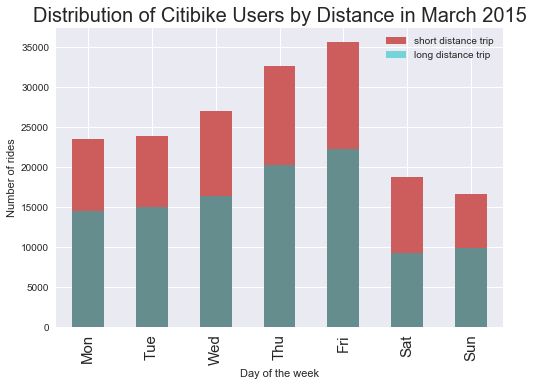

In [41]:
import pylab as pl
import seaborn as sns
fig = pl.figure()

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_s = 1
((df['date'][df['distance'] < avg].groupby([df['date'].dt.weekday]).count()) / norm_s).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='short distance trip')

norm_l = 1
ax = ((df['date'][df['distance'] > avg].groupby([df['date'].dt.weekday]).count()) / norm_l).plot(kind="bar", 
                                                                                              color='c', 
                                                                                              alpha=0.5,
                                                                                              label='long distance trip')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=15)
pl.xlabel('Day of the week')
pl.ylabel('Number of rides')
pl.title('Distribution of Citibike Users by Distance in March 2015', fontsize=20)
pl.legend()
pl.show()

## Figure 1a: Distribution of Citibike bikers by gender in January 2015, absolute counts

Note: the counts have errors of course. what is the error on the count statistics? 

for N counts the error is sqrt(N) - this is because counts follow a Poisson statistic

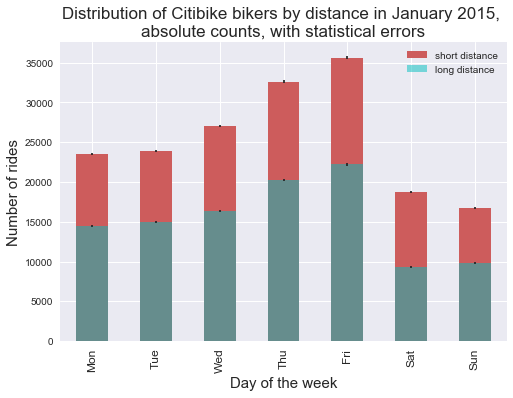

In [53]:
fig=pl.figure()

counts_s = df.date[df.distance < avg].groupby([df.date.dt.weekday]).count()
norm_s = 1
error_s = np.sqrt(counts_s)
ax=((counts_s) / norm_s).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_s) / norm_s, (error_s) / norm_s)], label='short distance')


counts_l = df.date[df.distance > avg].groupby([df.date.dt.weekday]).count()
norm_l = 1
error_l=np.sqrt(counts_l)
((counts_l) / norm_l).plot(kind="bar", alpha=0.5, yerr=[((error_l) / norm_l, (error_l) / norm_l)], 
                           color='c', label='long distance')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=12)
ax.set_ylabel ("Number of rides", fontsize=15)
ax.set_xlabel ("Day of the week", fontsize=15)
pl.legend(['short distance','long distance'],fontsize=10)
pl.title('Distribution of Citibike bikers by distance in January 2015, \nabsolute counts, with statistical errors', fontsize=17)
pl.show()

## Figure 1b: Distribution of Citibike bikers by gender in January 2015, absolute counts, with statistical errors

Note: These are absolute numbers. It is very hard to compare absolute numbers. Ratios (or proportions) are more ameable to comparison, so let's _normalize_ the distribution of man, and that of women, i.e. devide them by the total number of rides for that gender. 
(Notice that i have to normalize the errorbars too!)



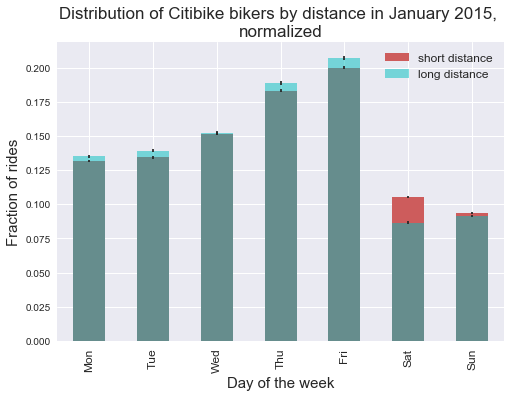

In [57]:
fig = pl.figure()

norm_s = counts_s.sum()
error_s = np.sqrt(counts_s)
((counts_s) / norm_s).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                           label='short distance')

norm_l = counts_l.sum()
ax = ((counts_l) / norm_l).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_l) / norm_l, (error_l) / norm_l)], 
                                color='c', label='long distance')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
ax.set_ylabel ("Fraction of rides", fontsize=15)
ax.set_xlabel ("Day of the week", fontsize=15)
pl.title('Distribution of Citibike bikers by distance in January 2015, \nnormalized', fontsize=17)
pl.legend(fontsize=12)
pl.show()

## Figure 2: Distribution of Citibike bikers by distance in January 2015, normalized

we can add up the week and weekend days, then this becomes a test of proportions, (like the one seen in the [employment notebook](https://github.com/fedhere/UInotebooks/blob/master/hypothesistesting/effectivenes%20of%20NYC%20Post-Prison%20Employment%20Programs.save.ipynb))